# Маркетинговый анализ приложения Procrastinate Pro+

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

---

## 1. Подготовим данные для анализа

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats as st
from datetime import datetime, timedelta

In [49]:
try:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

### 1.1 Предобработаем столбцы

In [50]:
visits.dtypes

User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object

In [51]:
orders.dtypes

User Id       int64
Event Dt     object
Revenue     float64
dtype: object

In [52]:
costs.dtypes

dt          object
Channel     object
costs      float64
dtype: object

In [53]:
# приведем название столбцов к нижнему регистру и уберем пробелы

visits = visits.rename(columns = {
    'User Id' : 'user_id',
    'Region' : 'region',
    'Device' : 'device',
    'Channel' : 'channel',
    'Session Start' : 'session_start',
    'Session End' : 'session_end'
})

orders = orders.rename(columns = {
    'User Id' : 'user_id',
    'Event Dt' : 'event_dt',
    'Revenue' : 'revenue'
})

costs = costs.rename(columns = {
    'Channel' : 'channel'
})

In [54]:
# приведем даты к нужному типу

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### 1.2. Проверим датасеты на дубликаты

In [55]:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
display(costs.duplicated().sum())

0

0

0

***Дубликаты отсутствуют.***

---

## 2. Зададим нужные функции для дальнейшего анализа.

### 2.1. Профили пользователей, удержание, конверсия, LTV.

In [56]:
# профили

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [95]:
# удержание

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [91]:
# конверсия

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
        
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


In [59]:
# LTV and ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### 2.2. Функции для визуализации.

In [60]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [61]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    
    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [62]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### 2.3. Функция для сглаживания фрейма

In [63]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

---

## 3. Исследовательский анализ данных.

### 3.1. Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

In [64]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


- *Установим момент и горизонт анализа данных.*
- *На календаре 1 ноября 2019 года, и зададим горизонт анализа 14 дней, так как по условиям принятая в компании окупаемость считается за 2 недели.*

In [65]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
ignore_horizon=False

In [66]:
profiles['dt'] =  pd.to_datetime(profiles['dt']).dt.date
min_analysis_date = profiles['dt'].min()
max_analysis_date =  observation_date - timedelta(days=horizon_days - 1)
print(f'Минимальная  дата привлечения: {min_analysis_date}\nМаксимальная дата привлечения: {max_analysis_date}')

Минимальная  дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-19


### 3.2. Профили пользователей по странам

- *Из каких стран приходят посетители?*
- *Какие страны дают больше всего платящих пользователей?*

In [67]:
q321 = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='user_id', ascending=False)

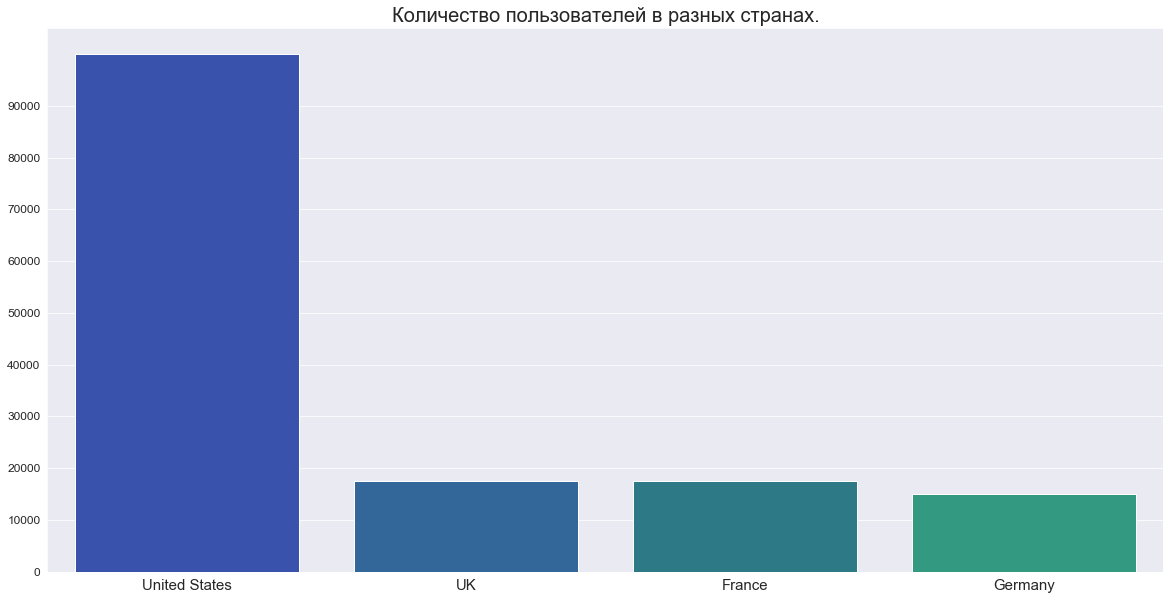

In [68]:
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))

plt.title('Количество пользователей в разных странах.', size = 20)

sns.barplot(data = q321, x = q321.index, y = 'user_id', palette = 'winter', saturation = 0.5)
plt.xlabel('')
plt.xticks(size = 15)

plt.ylabel('')
plt.yticks(range(0,100000, 10000), size = 12)

plt.show()

In [69]:
q322 = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

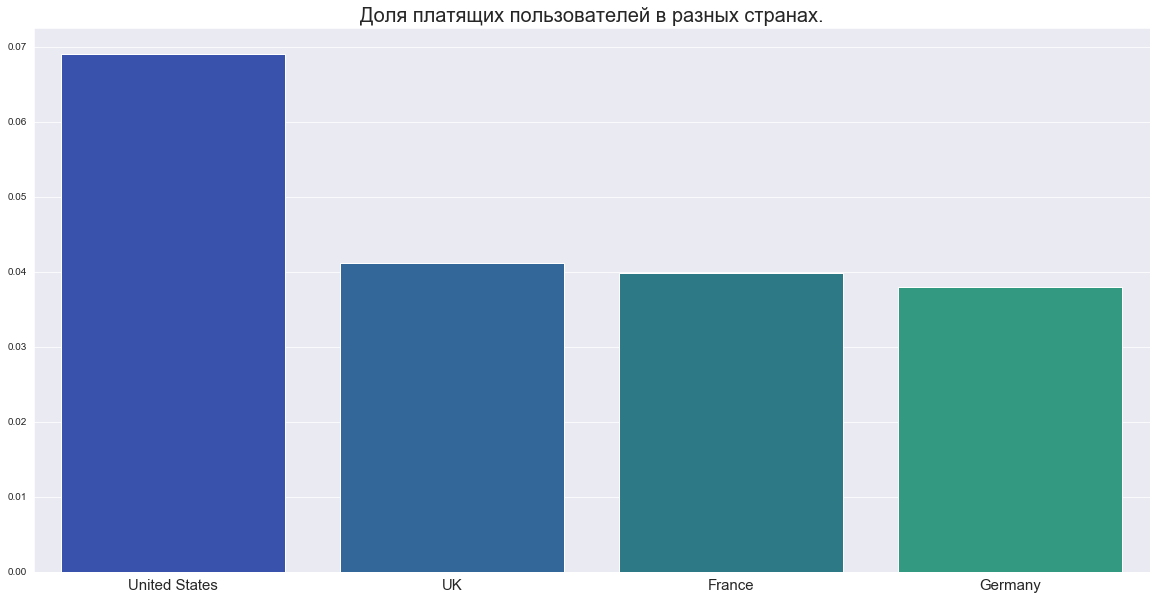

In [70]:
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))

plt.title('Доля платящих пользователей в разных странах.', size = 20)

sns.barplot(data = q322, x = q321.index, y = 'payer', palette = 'winter', saturation = 0.5)
plt.xlabel('')
plt.xticks(size = 15)

plt.ylabel('')

plt.show()

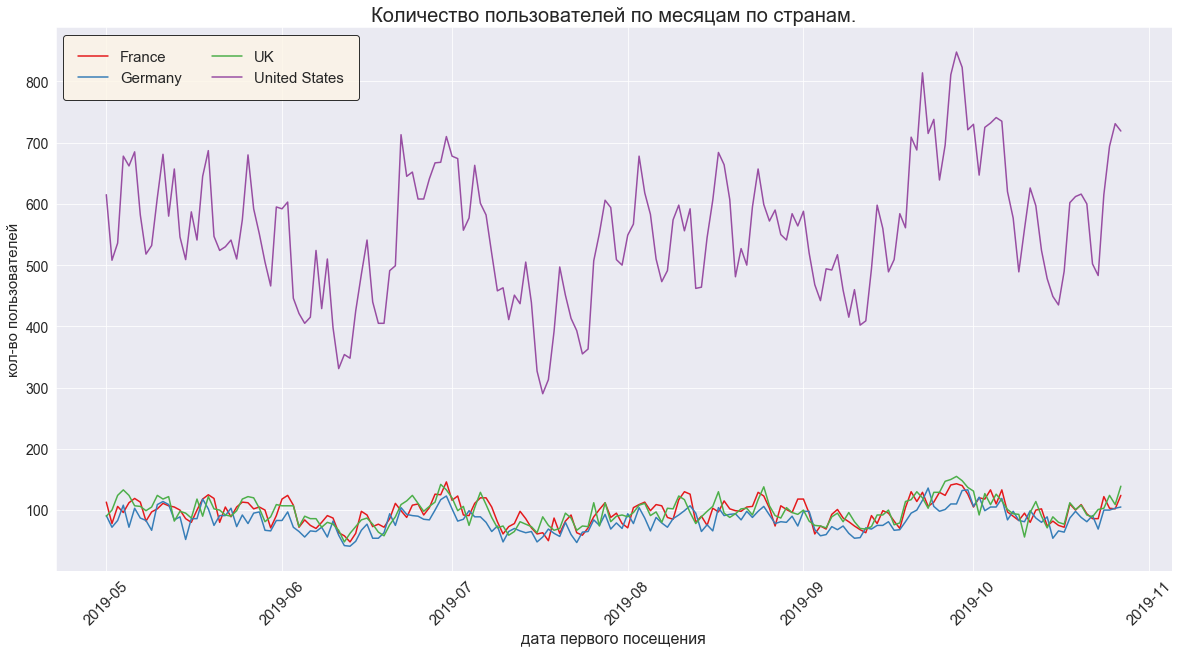

In [71]:
q323 = profiles.pivot_table(
        index='dt',  # даты первых посещений
        columns='region',  # страна переходов
        values='user_id',  # ID пользователей
        aggfunc='nunique',  # подсчёт уникальных значений
)

plt.figure(figsize = (20,10))
plt.title('Количество пользователей по месяцам по странам.', size = 20)

sns.lineplot(data = q323, palette = 'Set1', dashes=False)

plt.xlabel('дата первого посещения', size = 16)
plt.xticks(size = 15, rotation = 45)
plt.ylabel('кол-во пользователей', size = 15)
plt.yticks(size = 14)

plt.legend(shadow = False,
           fontsize = 15,
           ncol = 2,
           facecolor = 'oldlace',
           edgecolor = 'black',
           borderpad=1
          )

plt.show()

#### Выводы:

- *Платящие пользователи из стран Европы примерно равны 3.5-7%.*
- *Самая большая доля и количество платящих пользователей из США.*

### 3.3. Профили пользователей по устройствам

- *Какими устройствами они пользуются?*
- *С каких устройств чаще всего заходят платящие пользователи?*

In [72]:
q331 = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='user_id', ascending=False)

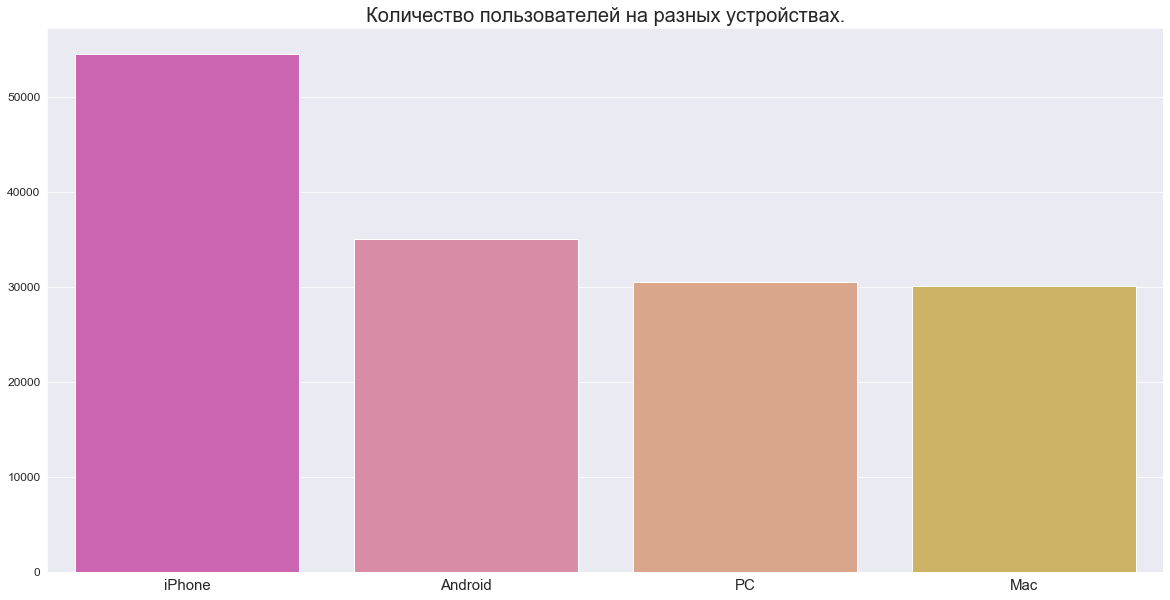

In [73]:
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))

plt.title('Количество пользователей на разных устройствах.', size = 20)

sns.barplot(data = q331, x = q331.index, y = 'user_id', palette = 'spring', saturation = 0.5)
plt.xlabel('')
plt.xticks(size = 15)

plt.ylabel('')
plt.yticks(size = 12)

plt.show()

In [74]:
q332 = (profiles.groupby(['device', 'payer'])
        .agg({'user_id': 'count'})
        .query('payer == True')
        .sort_values(by = 'user_id', ascending = False))

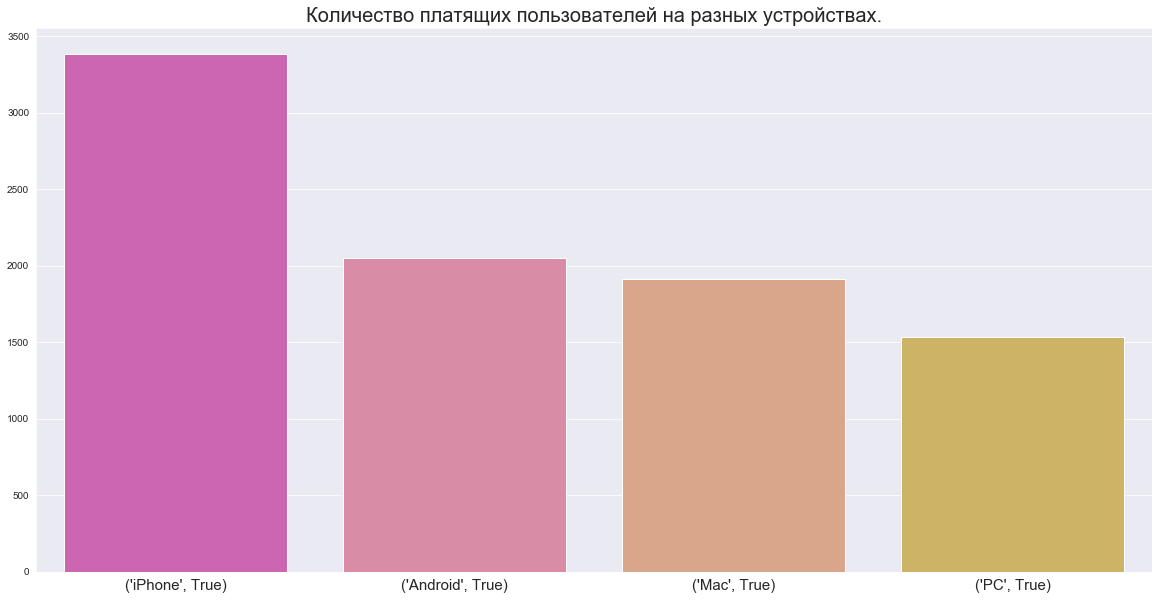

In [75]:
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))

plt.title('Количество платящих пользователей на разных устройствах.', size = 20)

sns.barplot(data = q332, x = q332.index, y = 'user_id', palette = 'spring', saturation = 0.5)
plt.xlabel('')
plt.xticks(size = 15)

plt.ylabel('')

plt.show()

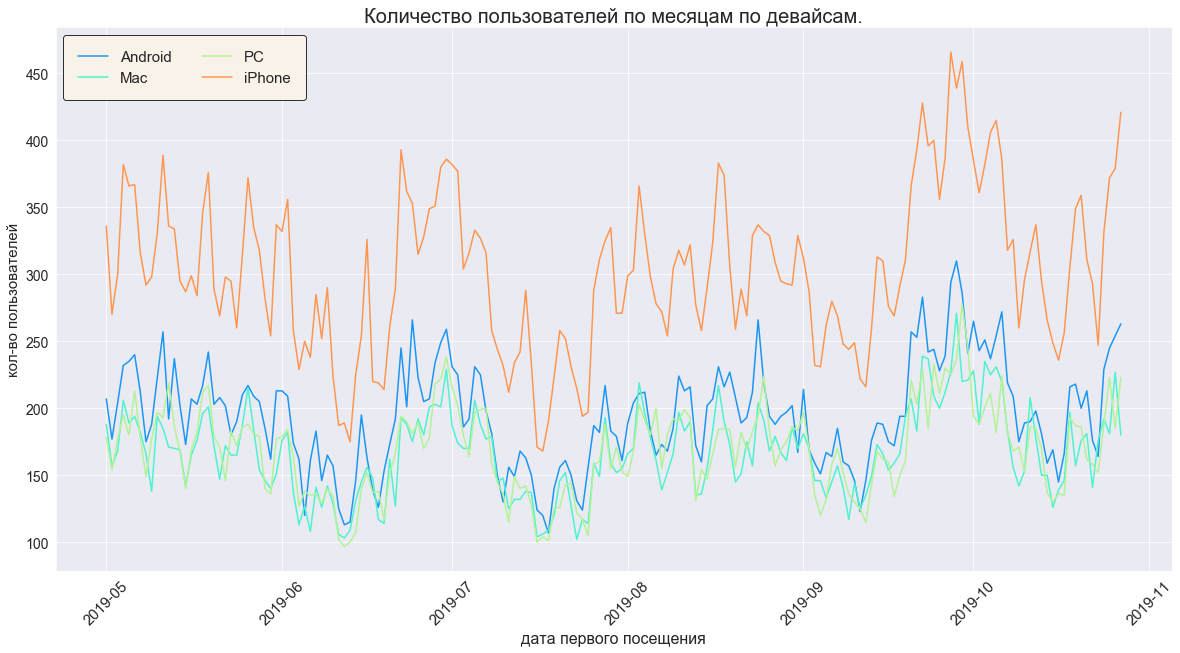

In [76]:
q333 = profiles.pivot_table(
        index='dt',  # даты первых посещений
        columns='device',  # устройство
        values='user_id',  # ID пользователей
        aggfunc='nunique',  # подсчёт уникальных значений
)

plt.figure(figsize = (20,10))
plt.title('Количество пользователей по месяцам по девайсам.', size = 20)

sns.lineplot(data = q333, palette = 'rainbow', dashes=False)

plt.xlabel('дата первого посещения', size = 16)
plt.xticks(size = 15, rotation = 45)
plt.ylabel('кол-во пользователей', size = 15)
plt.yticks(size = 14)

plt.legend(shadow = False,
           fontsize = 15,
           ncol = 2,
           facecolor = 'oldlace',
           edgecolor = 'black',
           borderpad=1
          )

plt.show()

#### Выводы:
- *Пользователи пользуются устройствами iPhone, Android, Mac и PC.*
- *Больше всего платящих пользователей, пользующихся iPhone. Android и Mac почти на одном уровне.*

### 3.4. Профили пользователей по каналам
- *По каким рекламным каналам шло привлечение пользователей?*
- *Какие каналы приносят больше всего платящих пользователей?*

In [77]:
q341 = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='user_id', ascending=False)

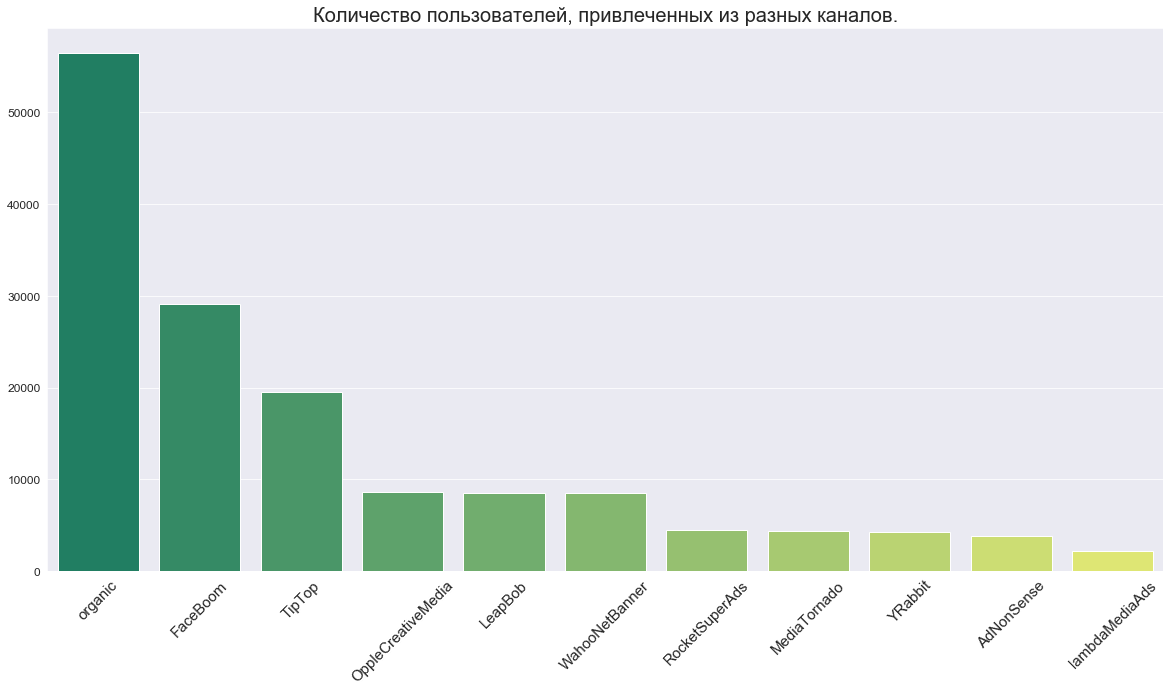

In [78]:
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))

plt.title('Количество пользователей, привлеченных из разных каналов.', size = 20)

sns.barplot(data = q341, x = q341.index, y = 'user_id', palette = 'summer', saturation = 0.8)
plt.xlabel('')
plt.xticks(size = 15, rotation = 45)

plt.ylabel('')
plt.yticks(size = 12)

plt.show()

In [79]:
q342 = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

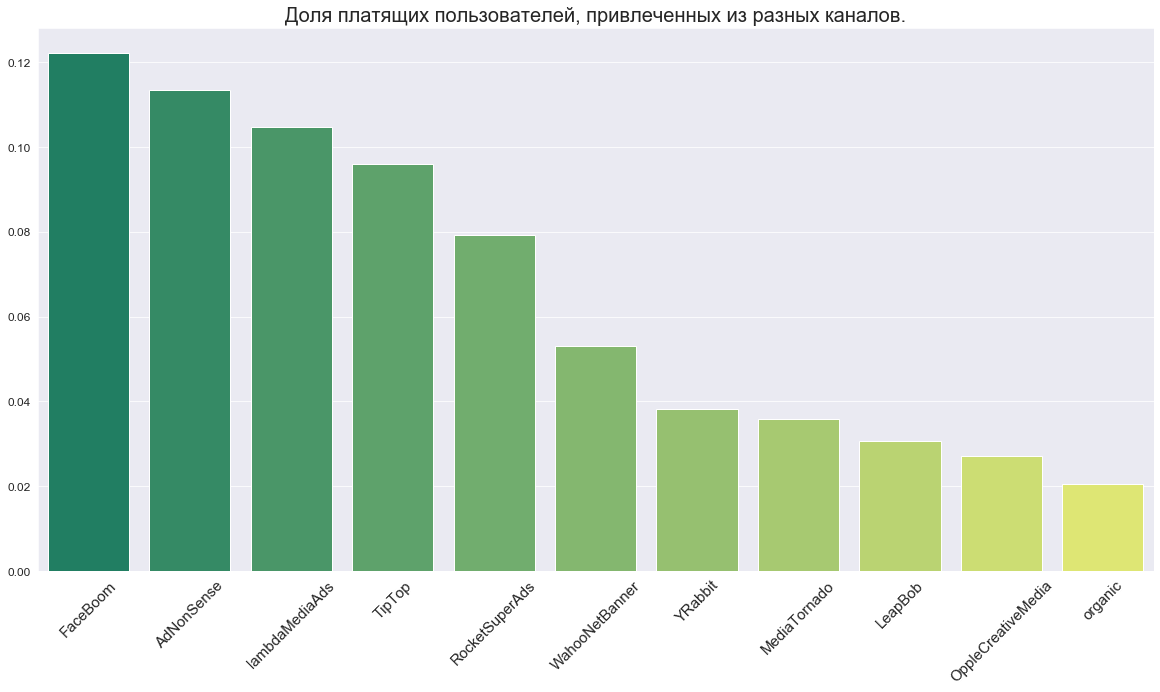

In [80]:
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))

plt.title('Доля платящих пользователей, привлеченных из разных каналов.', size = 20)

sns.barplot(data = q342, x = q342.index, y = 'payer', palette = 'summer', saturation = 0.8)
plt.xlabel('')
plt.xticks(size = 15, rotation = 45)

plt.ylabel('')
plt.yticks(size = 12)

plt.show()

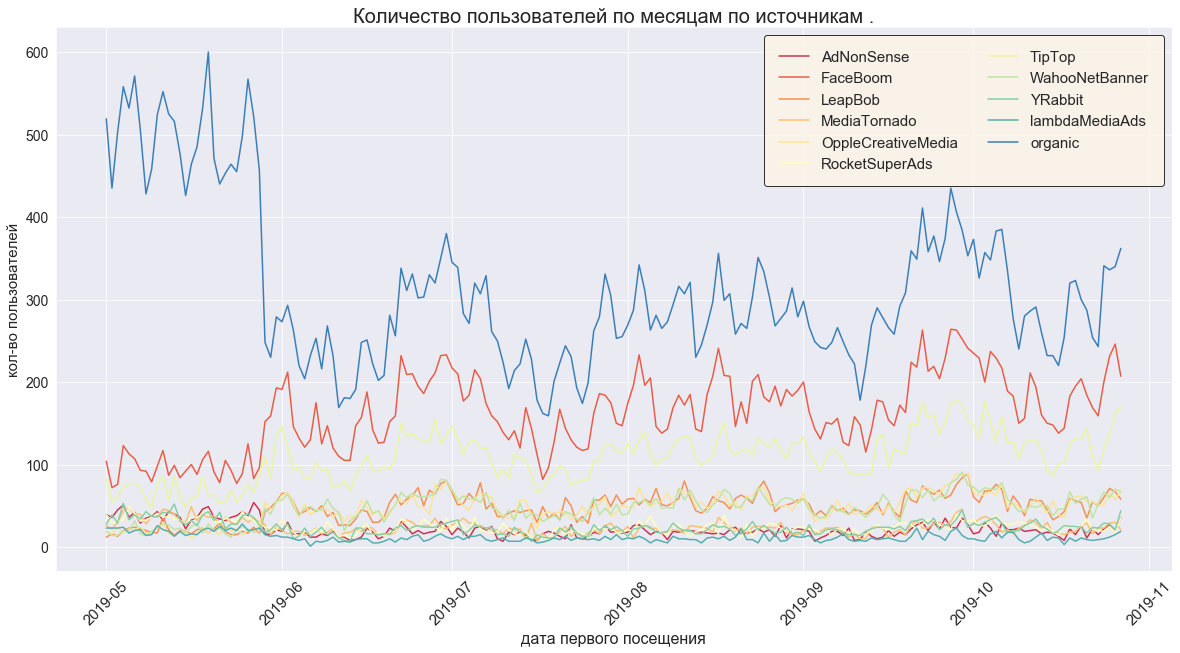

In [81]:
q343 = profiles.pivot_table(
        index='dt',  # даты первых посещений
        columns='channel',  # канал
        values='user_id',  # ID пользователей
        aggfunc='nunique',  # подсчёт уникальных значений
)

plt.figure(figsize = (20,10))
plt.title('Количество пользователей по месяцам по источникам .', size = 20)

sns.lineplot(data = q343, palette = 'Spectral', dashes=False)

plt.xlabel('дата первого посещения', size = 16)
plt.xticks(size = 15, rotation = 45)
plt.ylabel('кол-во пользователей', size = 15)
plt.yticks(size = 14)

plt.legend(shadow = False,
           fontsize = 15,
           ncol = 2,
           facecolor = 'oldlace',
           edgecolor = 'black',
           borderpad=1
          )

plt.show()

#### Вывод:

- *Привлечение пользователей шло по 11 различным каналам.*
- *Больше всего платящих пользователей с канала Faceboom.*
- *Больше всего пользователей приходит с канала organic, но платят они меньше всего, около 2%.*

---

## 4. Маркетинг
- *Сколько денег потратили? Всего / на каждый источник / по времени*
- *Сколько в среднем стоило привлечение одного покупателя из каждого источника?*

### 4.1. Сколько денег потратили? Всего / на каждый источник / по времени

Избавимся от органических пользователей, чтобы они не мешали анализу платных пользователей.

In [82]:
profiles = profiles.query('channel != "organic"')

#### 4.1.1. Сколько всего потратили денег?

In [83]:
print(f'Всего на маркетинг потратили: ${profiles.acquisition_cost.sum()}')

Всего на маркетинг потратили: $105497.3


#### 4.1.2. Сколько потратили денег на каждый источник?

In [84]:
q412 = (profiles
        .groupby('channel')
        .agg({'acquisition_cost': ['sum', 'mean']})
       )
q412.columns = ['sum_cost','mean_cost']
q412 = q412.sort_values(by = 'sum_cost', ascending = False)

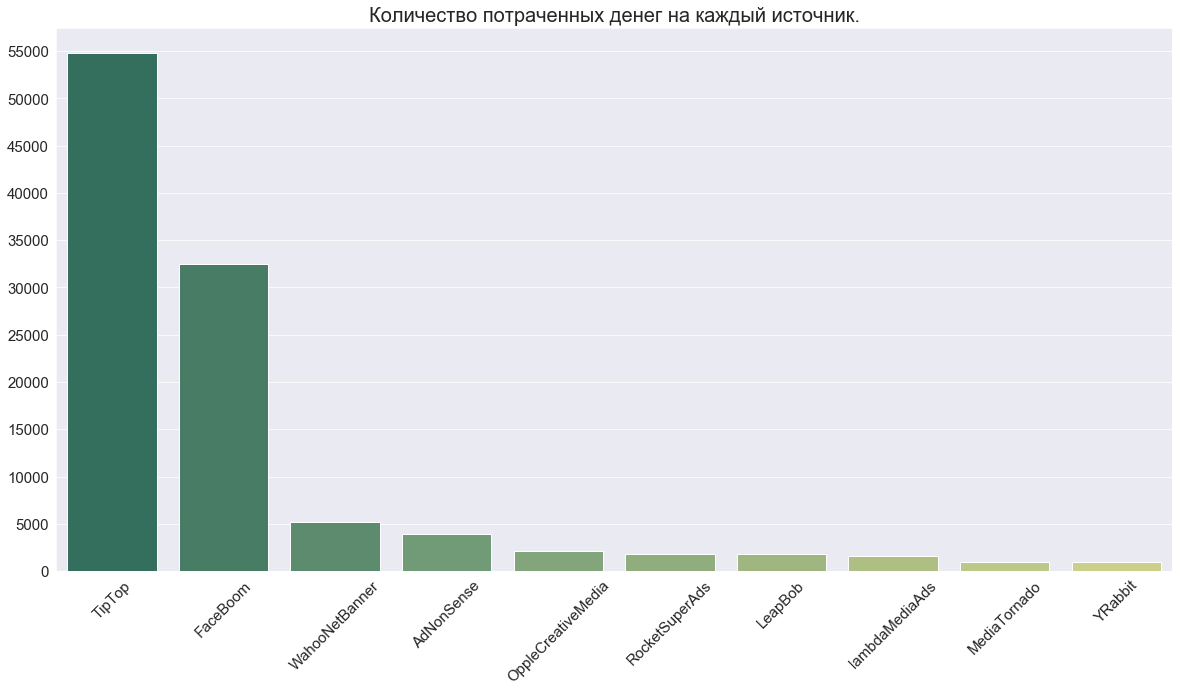

In [85]:
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))

plt.title('Количество потраченных денег на каждый источник.', size = 20)

sns.barplot(data = q412, x = q412.index, y = 'sum_cost', palette = 'summer', saturation = 0.5)
plt.xlabel('')
plt.xticks(size = 15, rotation = 45)

plt.ylabel('')
plt.yticks(range(0, 60000, 5000), size = 15)

plt.show()

#### Вывод:
*Больше всего потратили на TipTop, меньше всего на YRabbit.*

#### 4.1.3. Сколько потратили денег по времени?

In [86]:
q413 = profiles.pivot_table(
        index='dt',
        columns='channel',
        values='acquisition_cost',
        aggfunc='mean'
)

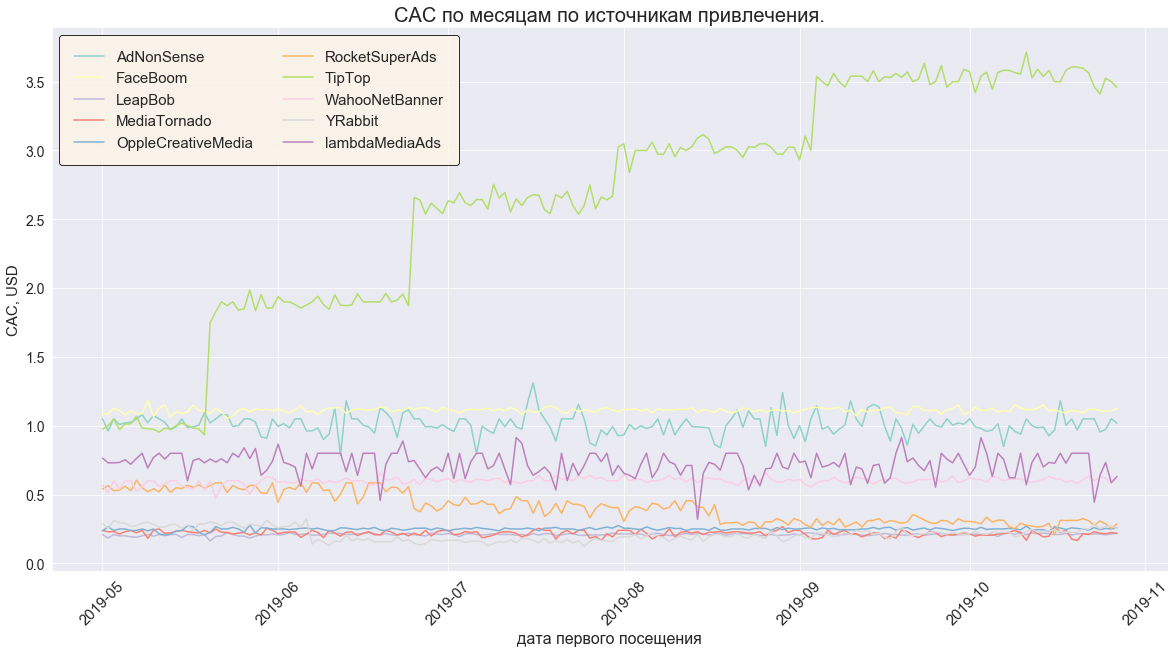

In [87]:
plt.figure(figsize = (20,10))
plt.title('CAC по месяцам по источникам привлечения.', size = 20)

sns.lineplot(data = q413, palette = 'Set3', dashes=False)

plt.xlabel('дата первого посещения', size = 16)
plt.xticks(size = 15, rotation = 45)
plt.ylabel('CAC, USD', size = 15)
plt.yticks(size = 14)

plt.legend(shadow = False,
           fontsize = 15,
           ncol = 2,
           facecolor = 'oldlace',
           edgecolor = 'black',
           borderpad=1
          )

plt.show()

### 4.2. Сколько в среднем стоило привлечение одного покупателя из каждого источника?

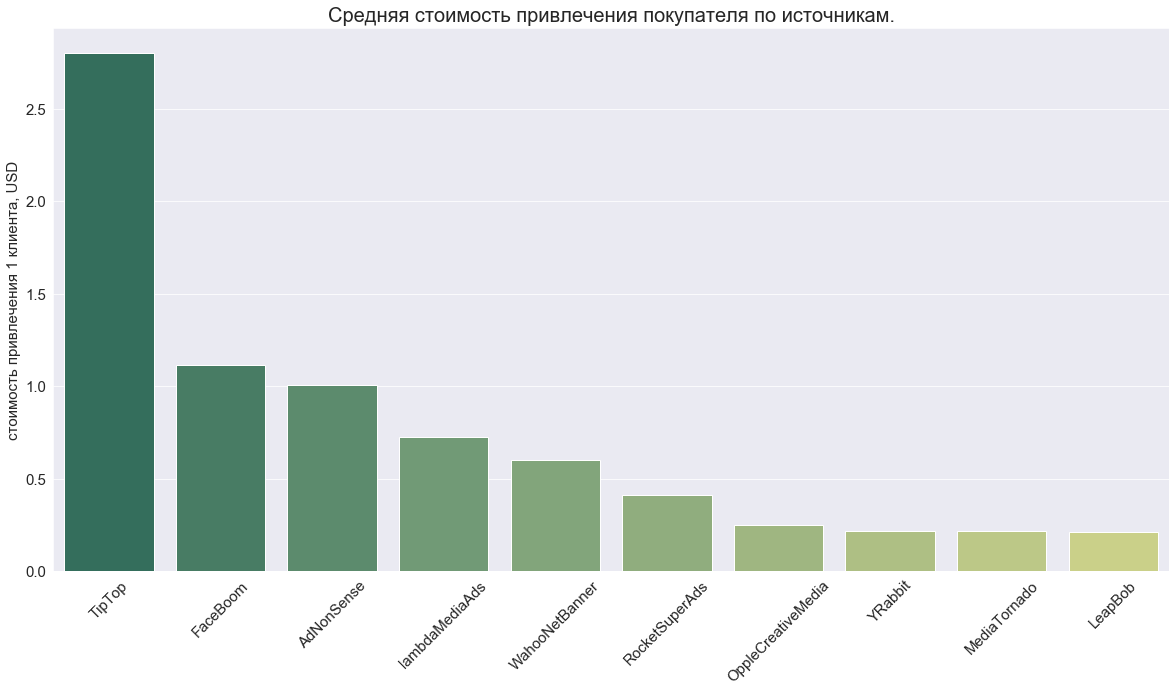

In [88]:
q412 = q412.sort_values(by = 'mean_cost', ascending = False)
plt.figure(figsize = (20, 10))

plt.title('Средняя стоимость привлечения покупателя по источникам.', size = 20)

sns.barplot(data = q412, x = q412.index, y = 'mean_cost', palette = 'summer', saturation = 0.5)
plt.xlabel('')
plt.xticks(size = 15, rotation = 45)

plt.ylabel('стоимость привлечения 1 клиента, USD', size = 15)
plt.yticks(size = 15)

plt.show()

#### Вывод:
*Самые дорогие были пользователи из TipTop, самые дешевые из LeapBob. MediaTornado, YRabbit.*

---

## 5. Оцените окупаемость рекламы для привлечения пользователей

### 5.1. Анализ общей окупаемость рекламы

*Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.*

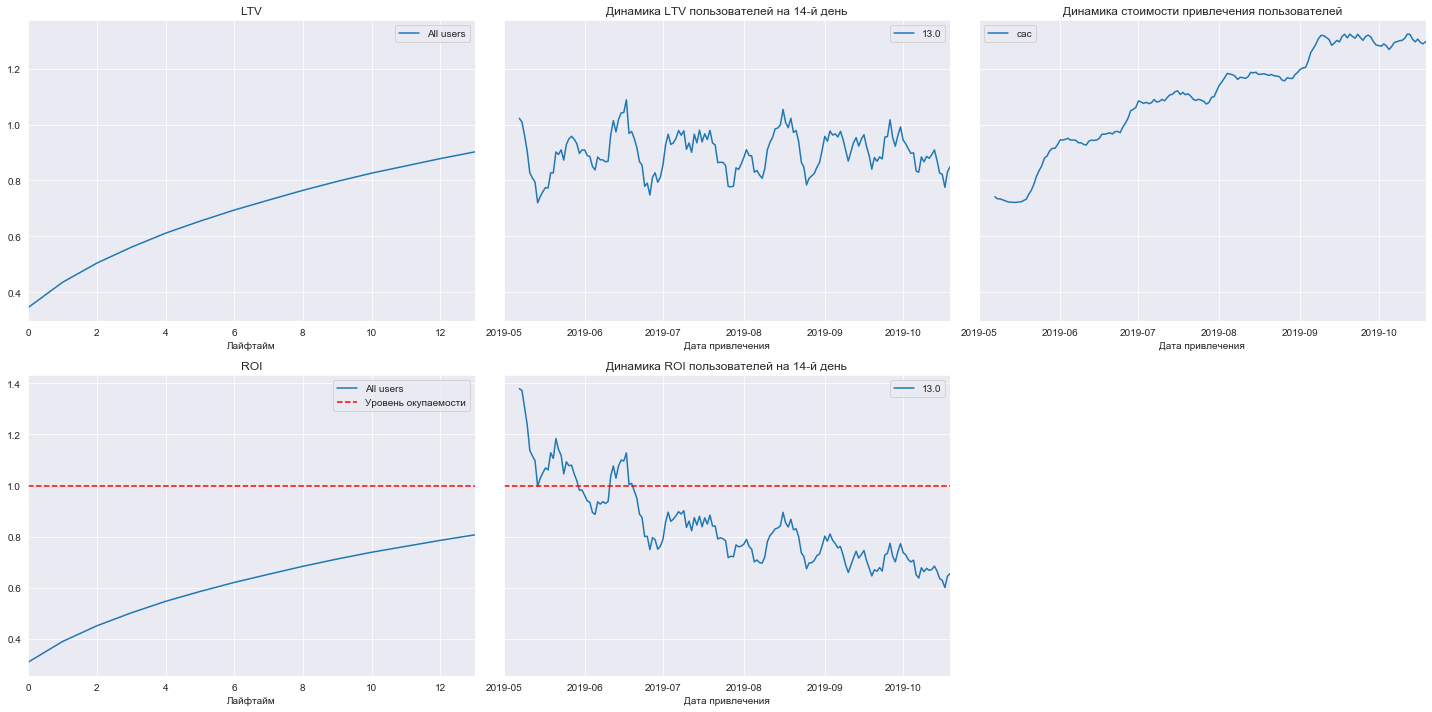

In [89]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

#### Вывод:
- Каждый месяц стоимость пользователей увеличивается.
- ROI не достигает значения 1, значит реклама не окупается.

### 5.2. Анализ окупаемости рекламы с разбивкой по устройствам

*Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.*

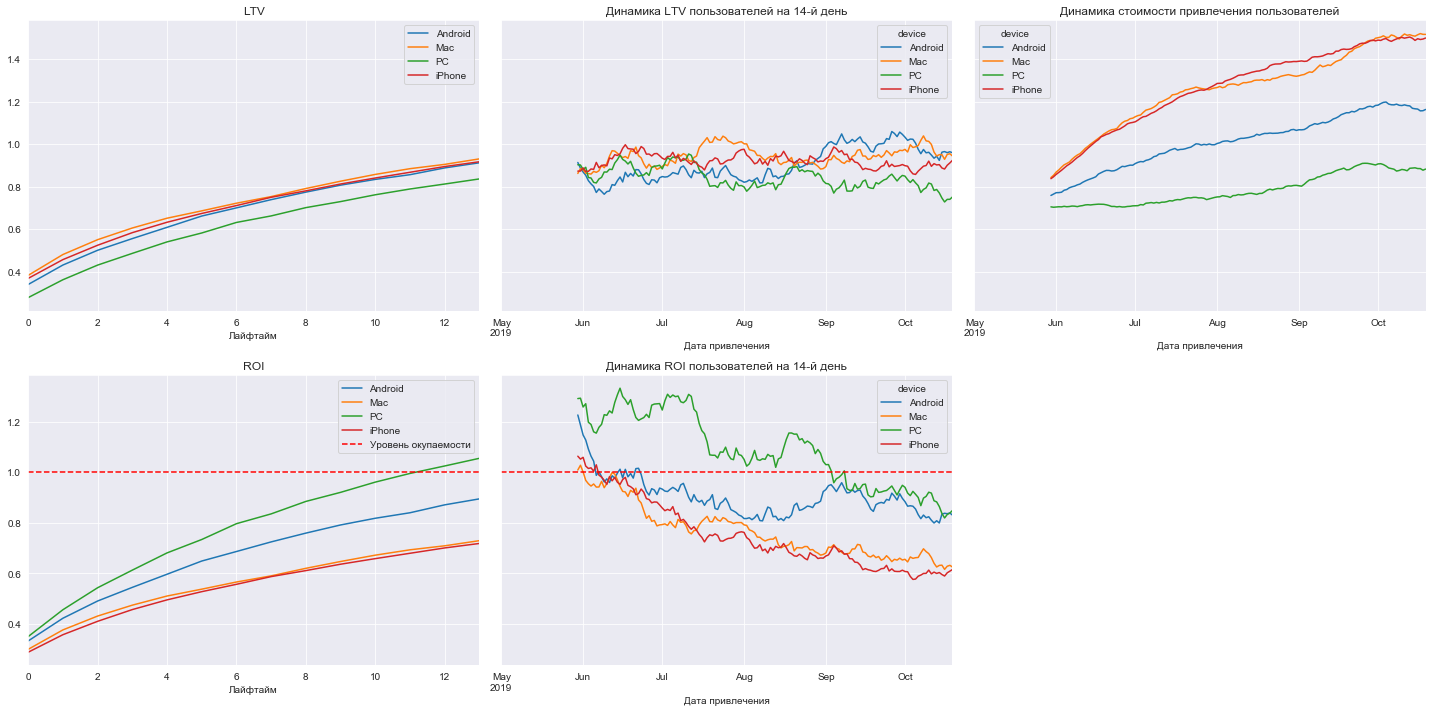

In [90]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
) 

#### Выводы:
- Самыми доходными являются MAC и iPhone.
- Самыми низкоприбыльными PC.
- Стоимость привлечения с каждым месяцев становится всё выше.
- Реклама окупается только у пользователей PC на 11 день, если смотреть в течение месяца, то не окупается ничего.

*Конверсия с разбивкой по устройствам.*

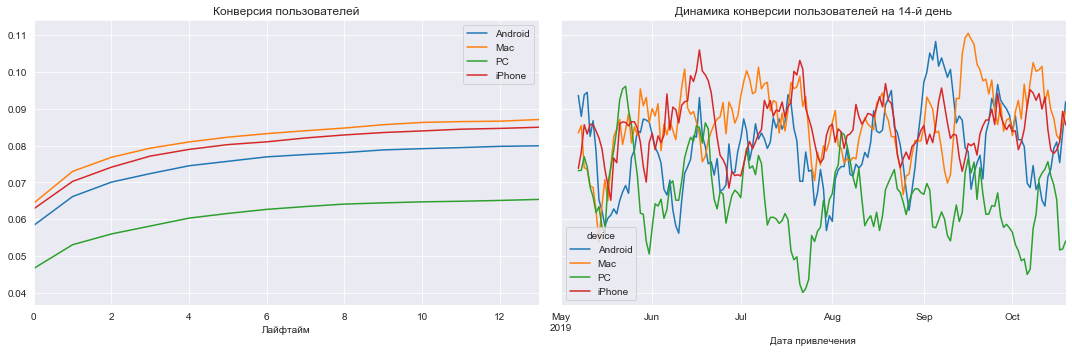

In [92]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

*Удержание с разбивкой по устройствам.*

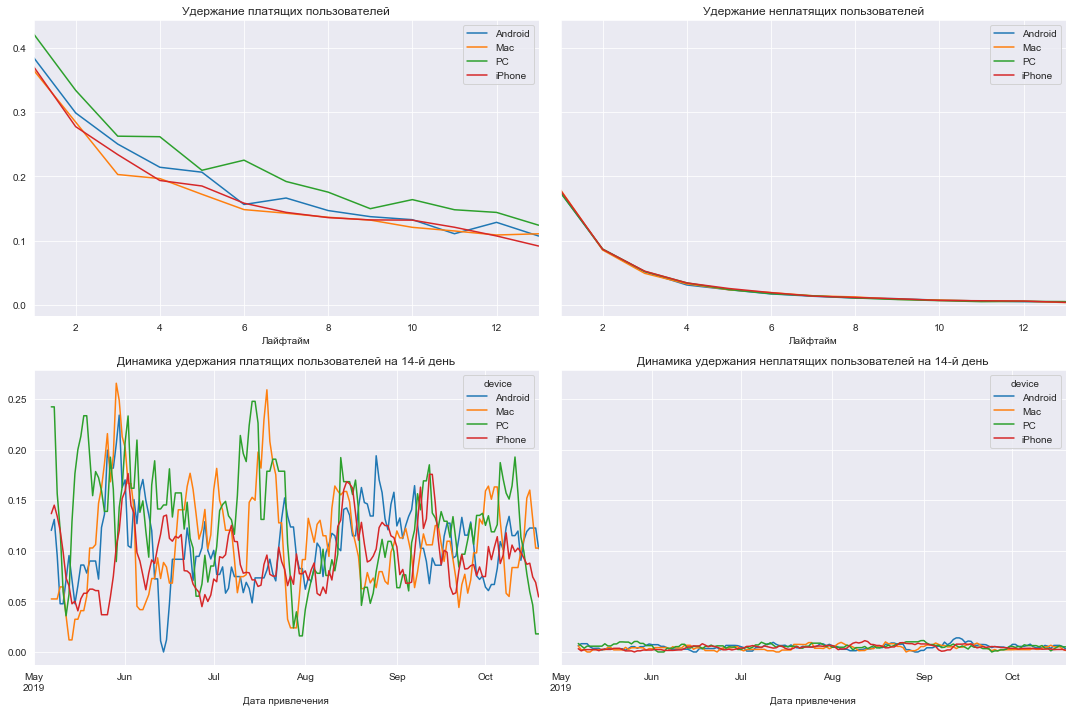

In [96]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### Выводы:
- Mac показывает самое низкое удержание, но в то же время самую высокую конверсию.
- А PC наоборот, лучше всего удерживаются, но конверсия хуже всех.
- Android и iPhone примерно одинаковые по этим критериям.

### 5.3. Анализ окупаемости рекламы с разбивкой по странам

*Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.*

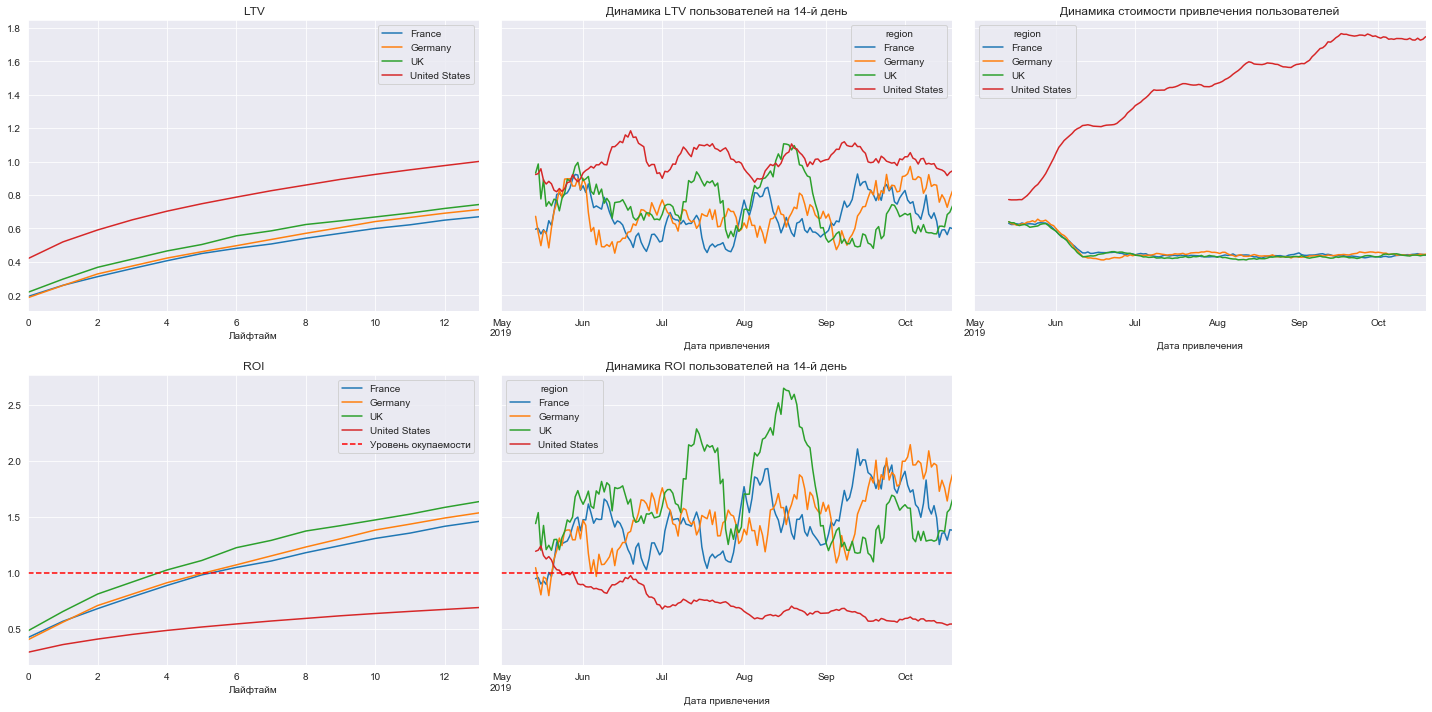

In [97]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

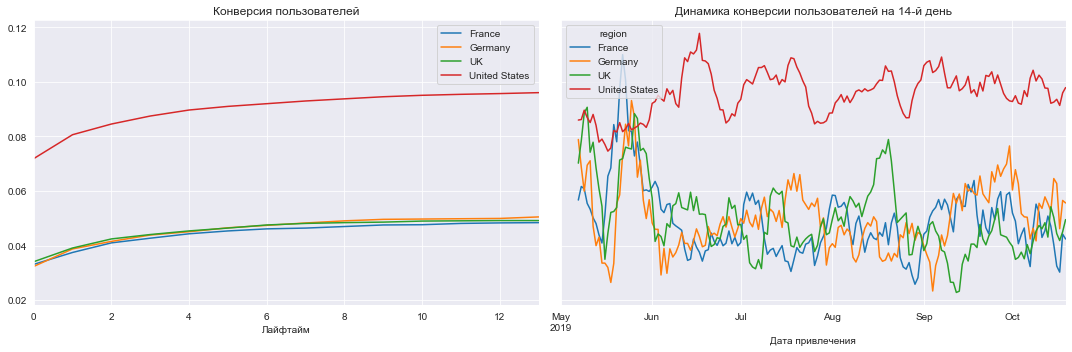

In [98]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
    )

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

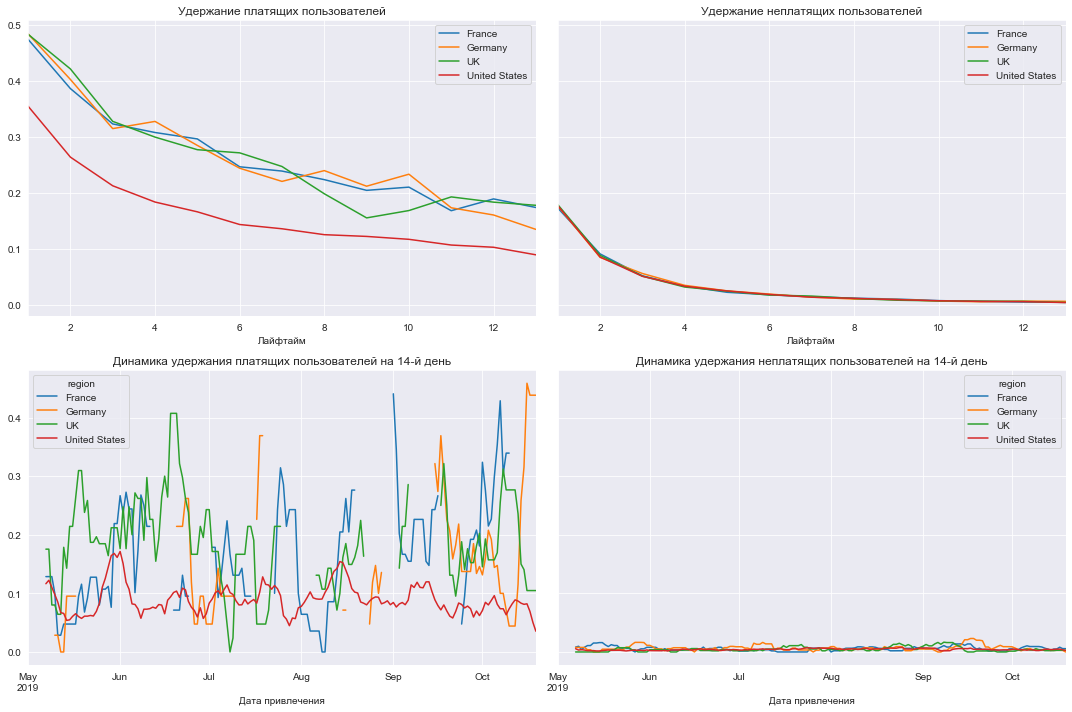

In [99]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### Выводы:
- Европа показывает почти одинаковые результаты по всем параметрам.
- Больше всего выделяются пользователи USA, они приносят больше всего денег, их конверсия гораздо выше, чем людей из Европы, но и их стоимость привлечения гораздо выше.
- Хуже всего удерживаются пользователи USA.
- Пользователи USA не окупаются.

### 5.4. Анализ окупаемости рекламы с разбивкой по рекламным каналам

*Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.*

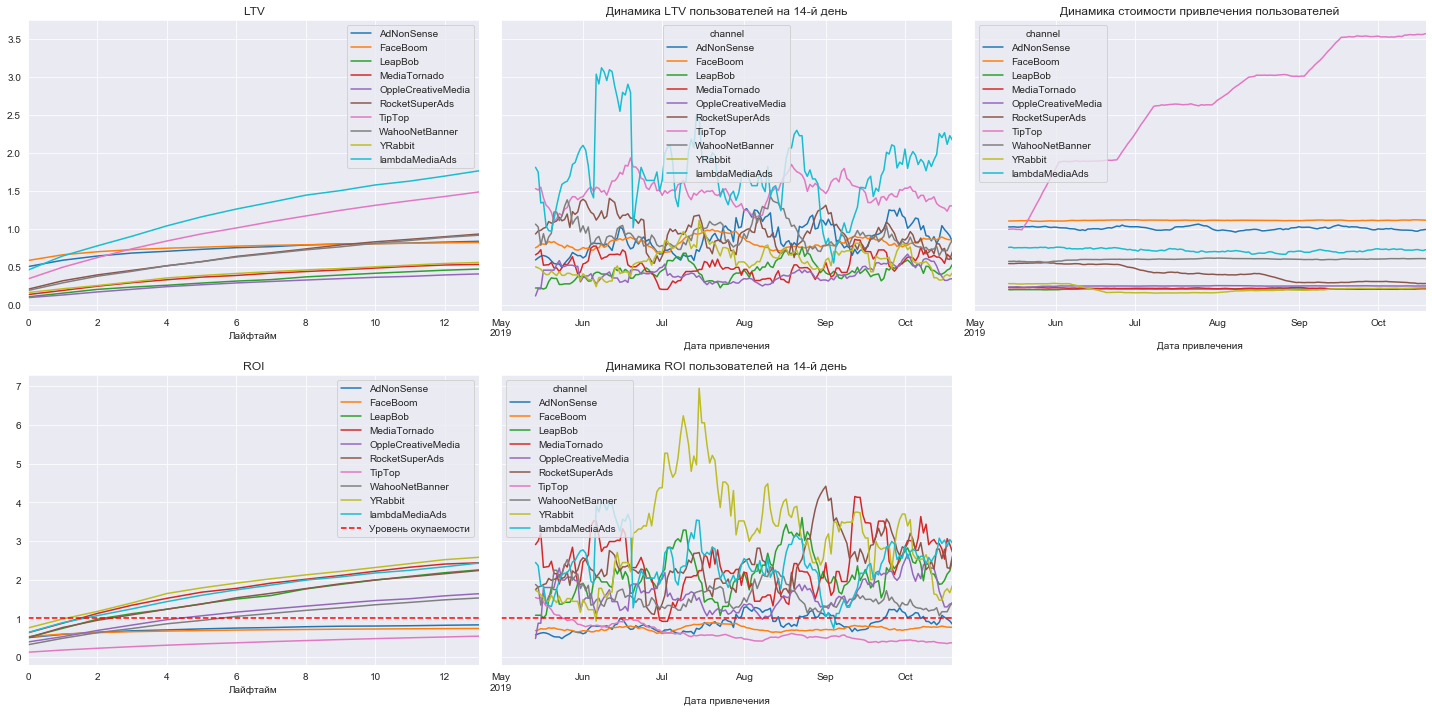

In [100]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
    
) 

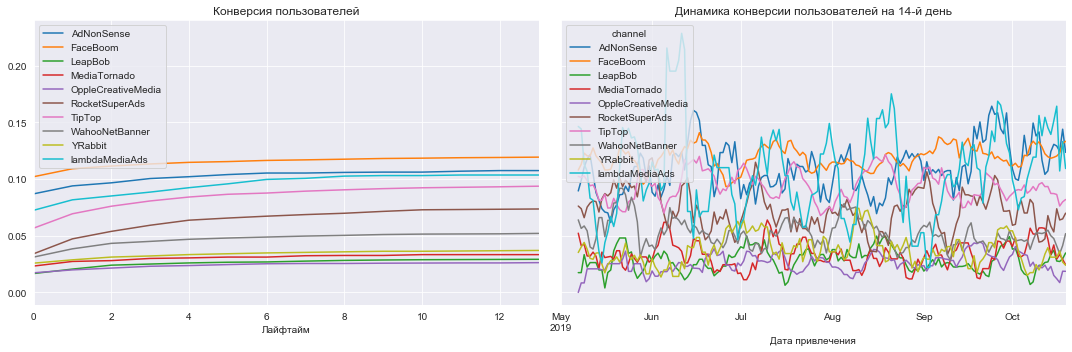

In [101]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
    )

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

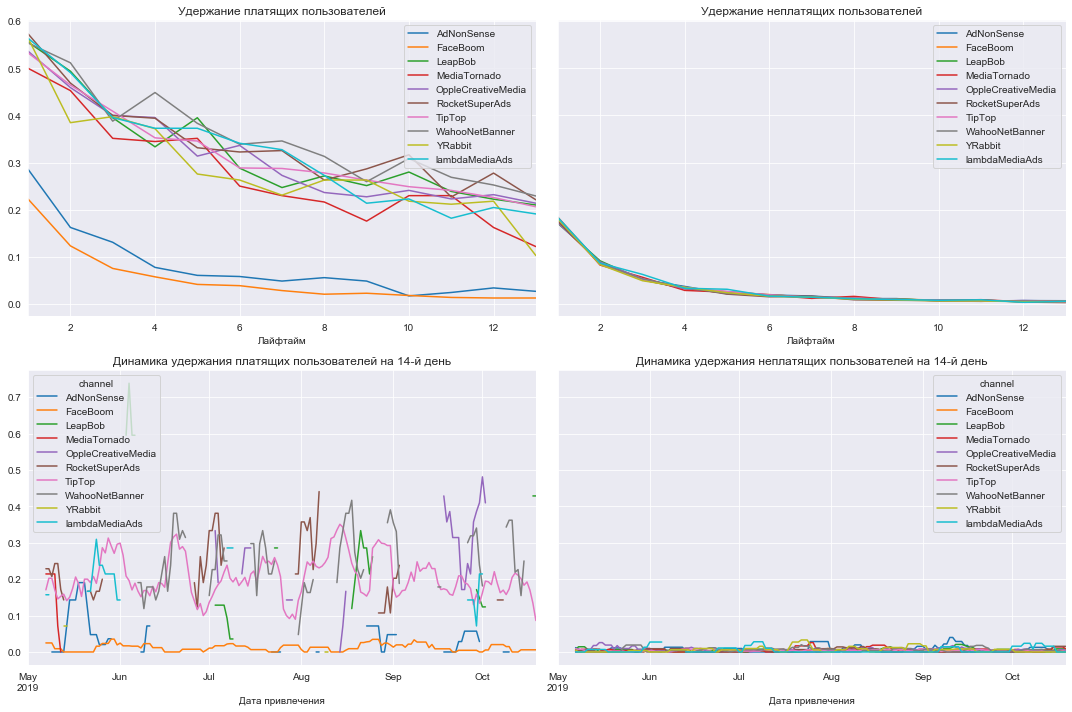

In [102]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### Выводы:
- *YRabbit, MediaTornado, lambdaMediaAds быстрее всего окупаются.*
- *AdNonSense, FaceBoom и TipTop не окупаются вообще, они приносят самые большие продажи, но клиенты стоят слишком дорого, поэтому данные источники неэффективны.*
- *AdNonSense, FaceBoom имеют как самую высокую конверсию в покупки, так и самые низкие показатели удержания пользователей.*

---

## 6. Выводы и проблемы:

1. ROI не достигает единицы => реклама не окупается
2. Отрицательное влияние на окупаемость рекламы оказывают большие траты на пользователей Mac, IPhone, пользователей USA, пользователей с TipTop и FaceBoom.
3. AdNonSense, FaceBoom - низкие показатели удержания, при этом эти каналы имеют самые высокие показатели конверсии.
4. Низкие показатели удержания пользователей USA, котроые обходятся дорого, но приносят максимум продаж и имеют самую высокую конверсию.

---

## 7. Рекомендации:

1. Снизить стоимости привлечения с AdNonSense, FaceBoom, TipTop и увеличить Retention Rate для данных групп.
2. Уменьшить CAC пользователей Mac и iPhone и улучшить показатель Retention Rate.
3. Каким-то образом оптимизировать пользователей PC и подталкивать их покупать больше.
4. Уменьшить CAC пользователей из USA.